<a href="https://colab.research.google.com/github/Katetuna/innopolis/blob/main/%D0%B0%D1%82%D1%82%D0%B5%D1%81%D1%82%D0%B0%D1%86%D0%B8%D1%8F_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Димполная работа на тему "Предсказание временных рядов на основе данных о продажах акций компании ТЕСЛА за период с 2010 - 2020 года"

## Введение. Постановка целей и задач.

Акции TSLA выросли в 2020 году с сумасшедшим всплеском + 100% только за 30 дней. Проанализировав данные, может быть, мы сможем узнать, почему? А также спрогнозировать на основании нескольких моделей, выбрав лучшую,  стоимость акций в будущем.

### Импорт Датафрейма, библиотек, написание функций.

In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 17.1 MB/s 
     |████████████████████████████████| 9.8 MB 43.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [34]:
# Здесь импортируем библиотеки и функции 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [113]:
# импорт SARIMAX 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, acovf, acf, pacf, pacf_yw, pacf_ols #функции частичной и автокорреляции
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # для определения (p,q) 
from statsmodels.tsa.seasonal import seasonal_decompose      # для ETS графиков
from pmdarima import auto_arima                              # для поиска ARIMA моделей (подбирает оптимальные параметры для модели)
from fbprophet import Prophet                                # для модели Профет
from statsmodels.tsa.holtwinters import ExponentialSmoothing # для модели Экспоненцальное сглаживание

# метрики
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse


In [135]:
# Импортируем данные.
df = pd.read_csv('/content/TSLA.csv',index_col='Date', parse_dates=True)


In [8]:
#Проверка, что все выгрузилось корректно.
print(df.head())


                 Open   High        Low      Close  Adj Close    Volume
Date                                                                   
2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300
2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100
2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800
2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800
2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900


### Выводы: цели и задачи работы поставлены. Загружены необходимые библиотеки и функции для правильной работы, а также сами данные. Проведен первичный анализ, что все выгрузилось верно.

### Знакомство с данными.

In [10]:
# Общая информация по датасету 
df.info()
len(df)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2416 entries, 2010-06-29 to 2020-02-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2416 non-null   float64
 1   High       2416 non-null   float64
 2   Low        2416 non-null   float64
 3   Close      2416 non-null   float64
 4   Adj Close  2416 non-null   float64
 5   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 132.1 KB


2416

In [11]:
# Проверка датасета на пропуски
df.isna()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,False,False,False,False,False,False
2010-06-30,False,False,False,False,False,False
2010-07-01,False,False,False,False,False,False
2010-07-02,False,False,False,False,False,False
2010-07-06,False,False,False,False,False,False
...,...,...,...,...,...,...
2020-01-28,False,False,False,False,False,False
2020-01-29,False,False,False,False,False,False
2020-01-30,False,False,False,False,False,False


In [13]:
# Проверка каждого признака на  отсутствие пропусков
df_check_nan = df.isna()
for i in df_check_nan.columns:
    print(f'Для признака {i} пропуски: ', df_check_nan[i].unique())

Для признака Open пропуски:  [False]
Для признака High пропуски:  [False]
Для признака Low пропуски:  [False]
Для признака Close пропуски:  [False]
Для признака Adj Close пропуски:  [False]
Для признака Volume пропуски:  [False]


In [51]:
# проверка типа данных
df.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

При знакомстве с данными получили следующую информацию:

В датасете 7 колонок(включая индексы). Колонку с индексами заменили на соответствущие даты. В датасете на дату содержится информация по ценам за день( цена открытия, наивысшая цена, низшая цена, цена закрытия, скорректированная цена и объем акций). Данные предоставлены в необходимом числовом формате.  В датасете отсутствуют нулевы денные. Всего 2416 строк

## Предобработка данных

### Фильтрация данных

Для анализа оставим колонки с информацией по цене открытия, закрытия и объемам акций

In [52]:
df_new = df[['Close', 'Volume']]
#проверка что все верно
print(df_new.head())

                Close    Volume
Date                           
2010-06-29  23.889999  18766300
2010-06-30  23.830000  17187100
2010-07-01  21.959999   8218800
2010-07-02  19.200001   5139800
2010-07-06  16.110001   6866900


### Вывод по этапу. Проведена фильтрация данных, оставлены только необходимые для анализа колонки.


## EDA или разведочный анализ данных.

Рассчитаем сколько в среднем было проадно акций за весь анализируемый период и их среднюю цену. Также посчитаем среднее взвешенное объема акций в зависимости от цены

In [22]:
# среднее
print("Срднее кол-во проданных акций за весь период: ", df_new['Volume'].mean())
print("Срдняя цена закрытия за весь период: ", df_new['Close'].mean())
# среднее взвешенное
wm = np.average(df_new['Volume'], weights = df_new['Close'])
print("Среднее взвешенное проданных акций с учетом стоимости акций:", wm)

Срднее кол-во проданных акций за весь период:  5572721.688741722
Срдняя цена закрытия за весь период:  186.40365078187054
Среднее взвешенное проданных акций с учетом стоимости акций: 7182459.707957235


Проверим распределение данных с помощью boxplot

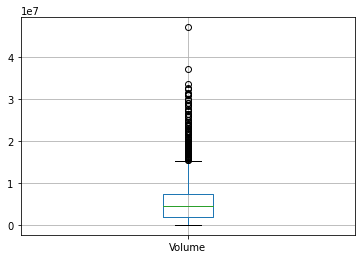

In [53]:
#Распределение объема проданных акций
df_new.boxplot(column='Volume')

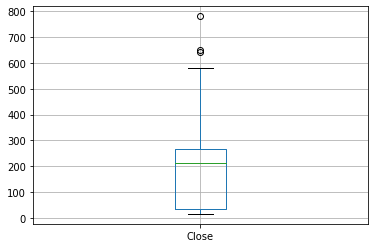

In [54]:
#Распределение цены акций
df_new.boxplot(column=['Close'])

На графиках видно, что объем проданных акций имеет большое кол-во выбросов, можно сделать предположение,что распределение не нормальное. Цена акций наоборот, имеет меньше выбросов, однако медиана смещена к верхнему квартилю.

Построим гистограмы, чтобы увидеть распредление данных

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f34272ae9d0>,
      dtype=object)

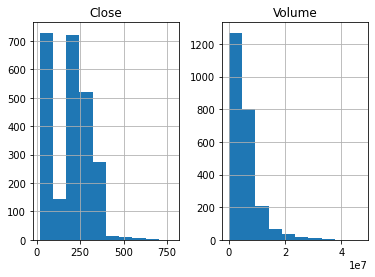

In [55]:
df_new.hist()

Форма гистограмм отличается от нормального распределения, у которого симметричная форма колокола с пиком посередине. У обеих гистограмм можно отметить смещение вправо. Также на гистрогаме цены можно отметить наличие двех пиков.

In [56]:
# выведем метрики
df_new.describe()

,Close,Volume
count,2416.000000,2.416000e+03
mean,186.403651,5.572722e+06
std,119.136020,4.987809e+06
min,15.800000,1.185000e+05
25%,34.400002,1.899275e+06
50%,212.960007,4.578400e+06
75%,266.774994,7.361150e+06
max,780.000000,4.706500e+07


Так как основная цель работы - спрогнозировать цену акции в будщем, далее в работе будет вестисть анализ данных по колонке Close.

Проведем тест Харки — Бера для определения номарльности распределения цены, чтобы подтвердить предположение об однородности. Для этого в существует функция jarque_bera(), которая возвращает значения данной статистики:

In [32]:
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(df_new['Close'], axis = 0)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print(itog)

        JB                p-value                 skew             kurtosis     
--------------------------------------------------------------------------------
33.574182353046034 5.1222283420672906e-08 0.01650409768371561 2.4234335885745026
--------------------------------------------------------------------------------


При достаточно большом значении статистики p-value мало, опровергаем нулевую гипотезу что данные однородны (статистика попала в «хвост» распределения).

Построим общий график, а также график скользящего среднего на 20 (кол-во рабочих дней в месяце) и на 100 дней.

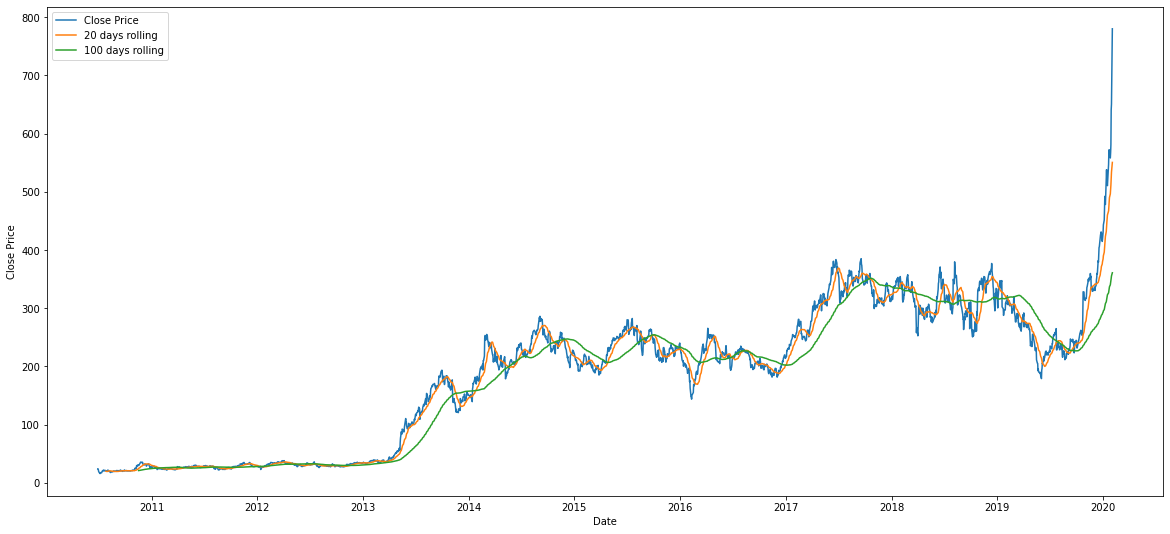

In [36]:
def plot_with_rolling(data,short_rolling,long_rolling,lbl='Close Price'):
    # Plot 
    fig, ax = plt.subplots(figsize=(20,9))

    ax.plot(data.index, data, label=lbl)
    ax.plot(short_rolling.index, short_rolling, label='20 days rolling')
    ax.plot(long_rolling.index, long_rolling, label='100 days rolling')
    ax.set_xlabel('Date')
    ax.set_ylabel(lbl)
    ax.legend()

    plt.show()

short = df_new.Close.rolling(window=20).mean()
long = df_new.Close.rolling(window=100).mean() 
plot_with_rolling(data=df_new.Close,short_rolling=short,long_rolling=long,lbl='Close Price')

По графику можно отметить растущий тренд,а также резкий рост цен со второй половины 2019 года

### ВЫВОД: 

## Построение моделей, анализ результатов.

Перед началом прогнозирования проведем анализ на стационарность врменного ряда

In [ ]:
#Проверка временного ряда на стационнарность
dftest = adfuller(df['Close'])
print ('adf: ', dftest[0])
print ('p-value: ', dftest[1])
print('Critical values: ', dftest[4])
if dftest[0]> dftest[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  1.40006850208616
p-value:  0.9971144530803391
Critical values:  {'1%': -3.4330810457844425, '5%': -2.862746538733181, '10%': -2.567412291147901}
есть единичные корни, ряд не стационарен


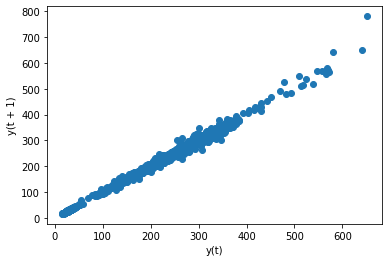

In [39]:
# Построим график запаздывания для поиска закономерностей в данных временного ряда.
from pandas.plotting import lag_plot
lag_plot(df_new['Close'])

Видим наличие тренда и корреляции


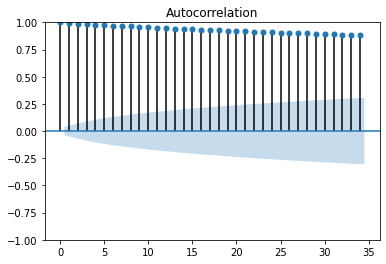

In [37]:
#Построение графика автокорреляции
acf(df_new['Close'])
plot_acf(df_new['Close']);

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


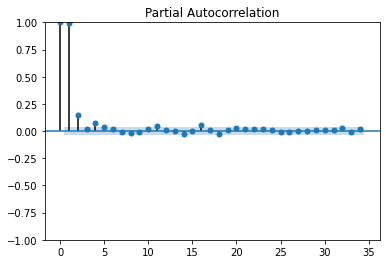

In [38]:
#Построение графика частичной автокорреляции
pacf(df_new['Close'])
plot_pacf(df_new['Close']);

Согласно проведенному анализу исследуемый временной ряд не стационарен.

В связи с большим кол-вом данных и увеличением времени подбора перейдем к недельному интервалу и среднему значению цены на нем, это избавит нас от выбросов и уменьшит колебания нашего ряда

[Text(0, 0.5, 'Close Price'), Text(0.5, 0, '')]

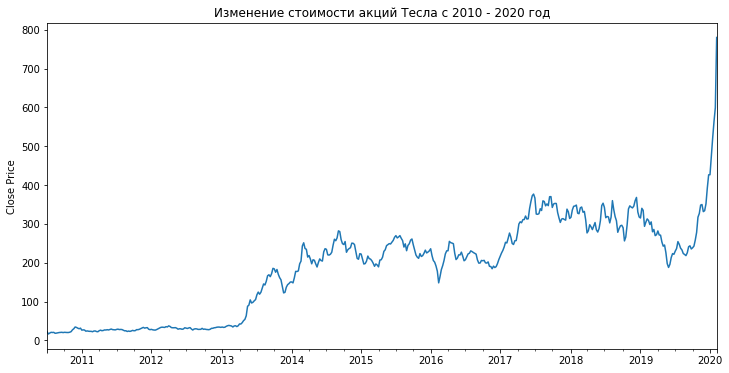

In [88]:
df_f = df_new.Close
df_f = df_f.resample('W').mean()
title = 'Изменение стоимости акций Тесла с 2010 - 2020 год' 
ylabel = 'Close Price' 
xlabel = '' 
ax = df_f.plot(figsize=(12,6), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

In [90]:
#Так как тип df_f - Series, на основе него создадим для дальнейшей работы датафрейм
df2 = pd.DataFrame(df_f, columns=['Close'])
#проверка
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 502 entries, 2010-07-04 to 2020-02-09
Freq: W-SUN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   502 non-null    float64
dtypes: float64(1)
memory usage: 7.8 KB


ETS декомпозиция

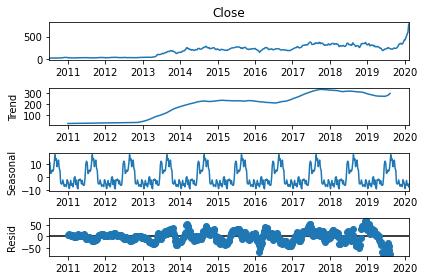

In [73]:
r = seasonal_decompose(df_f, model='additive')
r.plot();

Промежуточный вывод: Наблюдаем годовую сезонность и положительный тренд.

Построение моделей

In [99]:
# выделяем выборки, где тестовая размера 12 недель
train = df2.iloc[:len(df_f)-12]
test = df2.iloc[len(df_f)-12:]

In [97]:
#посмотрим на обучающую выборку
train.head()


,Close
Date,
2010-07-04,22.220000
2010-07-11,16.692500
2010-07-18,19.111999
2010-07-25,20.944000
2010-08-01,20.502000


In [101]:
#посмотрим на тестовую выборку
test.head(12)

,Close
Date,
2019-11-24,349.919995
2019-12-01,331.622505
2019-12-08,334.072003
2019-12-15,351.828003
2019-12-22,392.653998
2019-12-29,426.447502
2020-01-05,426.575005
2020-01-12,474.446002
2020-01-19,521.053992


In [92]:
from pmdarima import auto_arima    
auto_arima(df2['Close'],seasonal=True,m=52).summary() #включаем сезонность и указываем период сезонности = 1 год

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  502
Model:             SARIMAX(1, 1, 2)x(0, 0, [1], 52)   Log Likelihood               -1999.859
Date:                              Mon, 21 Mar 2022   AIC                           4009.718
Time:                                      19:38:14   BIC                           4030.801
Sample:                                           0   HQIC                          4017.990
                                              - 502                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9892      0.033     30.115      0.000       0.925       1.054
ma.L1         -0.5913      0.056    -10.529      0.000      -0.701      -0.481
ma.L2         -0.2408      0.053     -4.525      0.000      -0.345      -0.136
ma.S.L52       0.0848      0.049      1.723      0.085      -0.012       0.181
sigma2       171.0064      5.903     28.971      0.000     159.437     182.575
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             30305.61
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):              32.46   Skew:                             3.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Промежуточные выводы:

Получилась модель с параметрами SARIMAX(1, 1, 2)x(0, 0, [1], 52)

In [102]:
# создаем модель с подобранными параметрами
model_sarimax = SARIMAX(train['Close'],order=(1, 1, 2), seasonal_order=(0, 0, 1, 52))

#обучаем модель на обучающей выборке данных
results_sarimax = model_sarimax.fit()

#получаем результаты
results_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Close   No. Observations:                  490
Model:             SARIMAX(1, 1, 2)x(0, 0, [1], 52)   Log Likelihood               -1839.670
Date:                              Mon, 21 Mar 2022   AIC                           3689.339
Time:                                      19:42:36   BIC                           3710.301
Sample:                                  07-04-2010   HQIC                          3697.572
                                       - 11-17-2019                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8011      0.185      4.323      0.000       0.438       1.164
ma.L1         -0.5287      0.186     -2.842      0.004      -0.893      -0.164
ma.L2         -0.2746      0.045     -6.118      0.000      -0.363      -0.187
ma.S.L52       0.1001      0.038      2.618      0.009       0.025       0.175
sigma2       108.3146      5.039     21.496      0.000      98.439     118.190
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               101.45
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):              16.69   Skew:                            -0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [103]:
#предсказываем значения,передав модели results точку начала и окончания
prediction_sarimax = results_sarimax.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False, typ='levels').rename(' Predictions SARIMAX(1, 1, 2)x(0, 0, [1], 52)	')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


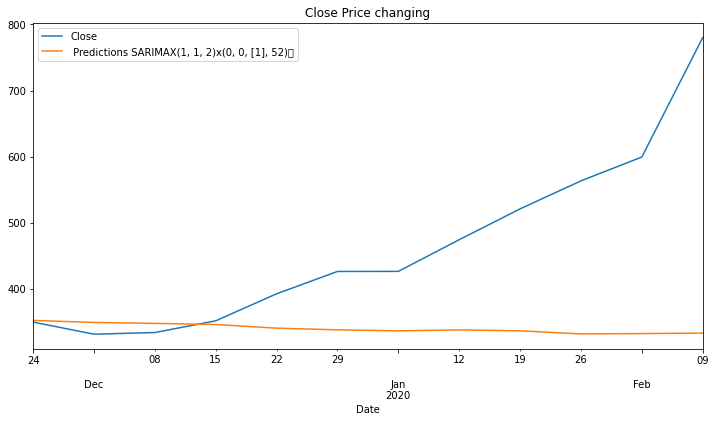

In [105]:
#сравниваем прогноз и тестовую выборку
ax = test['Close'].plot(legend=True, figsize=(12,6),title='Close Price changing')
prediction_sarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [108]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE
mae_error = mean_absolute_error(test['Close'], prediction_sarimax)
mse_error = mean_squared_error(test['Close'], prediction_sarimax)
rmse_error = rmse(test['Close'], prediction_sarimax)
mape_error = np.mean(np.abs(prediction_sarimax - test['Close'])/test['Close'])*100

print(f'SARIMAX(0, 1, 2)x(2, 0, [], 7) MAE Error: {mae_error:11.10}')
print(f'SARIMAX(0, 1, 2)x(2, 0, [], 7) MSE Error: {mse_error:11.10}')
print(f'SARIMAX(0, 1, 2)x(2, 0, [], 7) RMSE Error: {rmse_error:11.10}')
print(f'SARIMAX(0, 1, 2)x(2, 0, [], 7) MAPE Error: {mape_error:11.10}')

SARIMAX(0, 1, 2)x(2, 0, [], 7) MAE Error:  127.974433
SARIMAX(0, 1, 2)x(2, 0, [], 7) MSE Error: 33007.87855
SARIMAX(0, 1, 2)x(2, 0, [], 7) RMSE Error: 181.6807049
SARIMAX(0, 1, 2)x(2, 0, [], 7) MAPE Error: 22.81866178


In [109]:
#делаем прогноз на будущее - 12 недель вперед

# обучаем модель на всем датасете
fut_model_sarimax = SARIMAX(df2['Close'],order=(1, 1, 2), seasonal_order=(0, 0, 1, 52))
fut_results_sarimax = fut_model_sarimax.fit()
fut_results_sarimax.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Close   No. Observations:                  502
Model:             SARIMAX(1, 1, 2)x(0, 0, [1], 52)   Log Likelihood               -1999.859
Date:                              Mon, 21 Mar 2022   AIC                           4009.718
Time:                                      19:48:42   BIC                           4030.801
Sample:                                  07-04-2010   HQIC                          4017.990
                                       - 02-09-2020                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9892      0.033     30.115      0.000       0.925       1.054
ma.L1         -0.5913      0.056    -10.529      0.000      -0.701      -0.481
ma.L2         -0.2408      0.053     -4.525      0.000      -0.345      -0.136
ma.S.L52       0.0848      0.049      1.723      0.085      -0.012       0.181
sigma2       171.0064      5.903     28.971      0.000     159.437     182.575
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             30305.61
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):              32.46   Skew:                             3.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

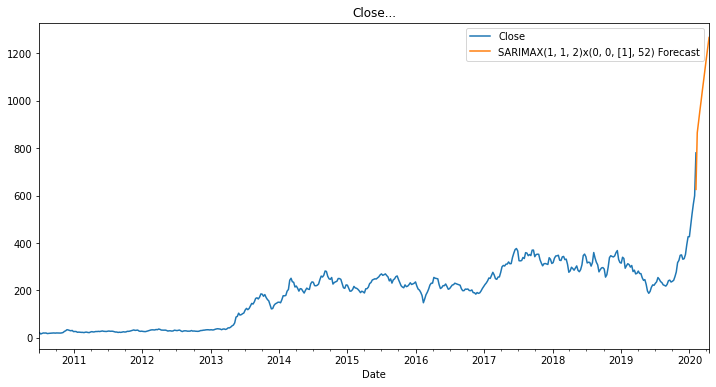

In [111]:
#задаем точки будущего
fut_fcast_sarimax = fut_results_sarimax.predict(len(df2)-1,len(df2)+9,typ='levels').rename('SARIMAX(1, 1, 2)x(0, 0, [1], 52) Forecast')

#строим график на будущее
ax = df2['Close'].plot(legend=True, figsize=(12,6),title='Close...') 
fut_fcast_sarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)

Выводы работы метода SARIMAX
to do

3й метод прогнозирования "Экспоненциальное сглаживание" (Exponential smoothing)

In [114]:
# создаем модель с подобранными параметрами
model_exps = ExponentialSmoothing(train['Close'], seasonal_periods=52, trend = 'add')# годовая сезонность

#обучаем модель на обучающей выборке данных
model_exps.fit()

In [115]:
#посмотрим на подобранные параметры модели
model_exps.params

{'damping_trend': nan,
 'initial_level': 22.577711519333395,
 'initial_seasons': array([], dtype=float64),
 'initial_trend': 0.664167386913011,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.9996726336716957,
 'smoothing_seasonal': nan,
 'smoothing_trend': 0.00023632206326520435,
 'use_boxcox': False}

In [116]:
#предсказываем значения,передав модели results точку начала и окончания
prediction_exps = model_exps.predict(model_exps.params, start=test.index[0], end=test.index[-1])

In [117]:
# определяем точку начала для прогноза
test.index[0]


Timestamp('2019-11-24 00:00:00', freq='W-SUN')

In [118]:
# определяем точку окончания для прогноза
test.index[-1]

Timestamp('2020-02-09 00:00:00', freq='W-SUN')

In [ ]:
prediction_exps

In [120]:
#преобразуем в датафрейм с индексами
prediction_exps = pd.DataFrame(prediction_exps)
prediction_exps.index = pd.date_range("2019-11-24 00:00:00", periods=12, freq="W-SUN")

prediction_exps.columns = ['prediction_exps']

In [121]:
#проверим
prediction_exps.head()

,prediction_exps
2019-11-24,349.187507
2019-12-01,349.851918
2019-12-08,350.516329
2019-12-15,351.180739
2019-12-22,351.845150


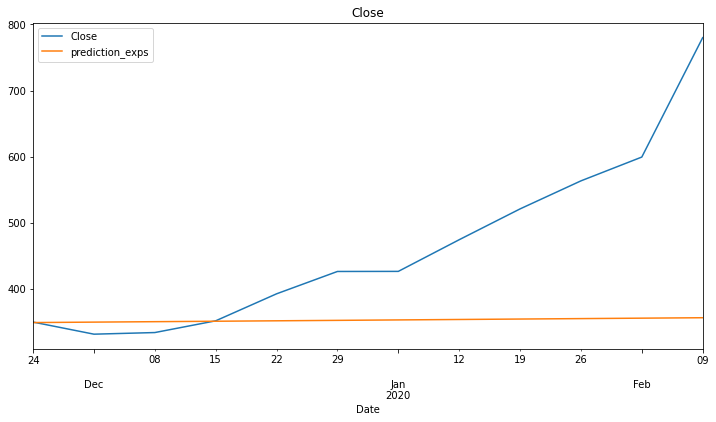

In [122]:
#сравниваем прогноз и тестовую выборку
ax = test['Close'].plot(legend=True, figsize=(12,6),title='Close')
prediction_exps['prediction_exps'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [124]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE
mae_error = mean_absolute_error(test['Close'], prediction_exps['prediction_exps'])
mse_error = mean_squared_error(test['Close'], prediction_exps['prediction_exps'])
rmse_error = rmse(test['Close'], prediction_exps['prediction_exps'])
mape_error = np.mean(np.abs(prediction_exps['prediction_exps'] - test['Close'])/test['Close'])*100

print(f'Exponential smoothing MAE Error: {mae_error:11.10}')
print(f'Exponential smoothing MSE Error: {mse_error:11.10}')
print(f'Exponential smoothing RMSE Error: {rmse_error:11.10}')
print(f'Exponential smoothing MAPE Error: {mape_error:11.10}')

Exponential smoothing MAE Error: 115.5640255
Exponential smoothing MSE Error: 28124.84638
Exponential smoothing RMSE Error: 167.7046403
Exponential smoothing MAPE Error: 20.41979624


In [127]:
#делаем прогноз на будущее

# обучаем модель на всем датасете
fut_model_exps = ExponentialSmoothing(df2['Close'], seasonal_periods=12, trend = 'add')
fut_model_exps.fit()

#задаем точки будущего
fut_fcast_exps = fut_model_exps.predict(fut_model_exps.params, start=len(df2)-1, end=len(df2)+9)

#преобразуем в датафрейм с индексами
fut_fcast_exps = pd.DataFrame(fut_fcast_exps)
fut_fcast_exps.index = pd.date_range('2020-02-09 00:00:00', periods=11, freq="W-SUN")
fut_fcast_exps.columns = ['fut_fcast_exps']

In [128]:
#проверим
fut_fcast_exps.head()

,fut_fcast_exps
2020-02-09,630.264822
2020-02-16,840.654571
2020-02-23,901.309144
2020-03-01,961.963717
2020-03-08,1022.618291


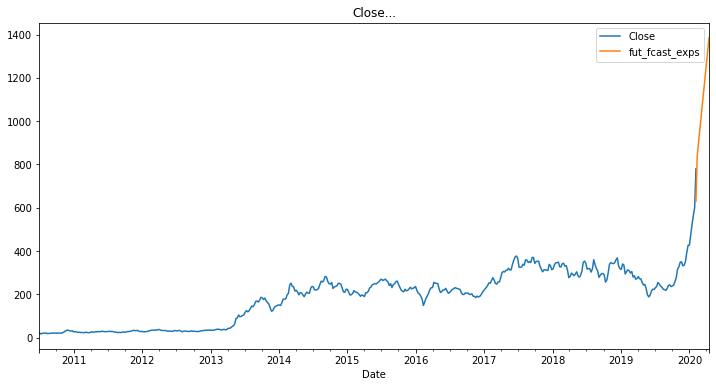

In [129]:
#строим график на будущее
ax = df2['Close'].plot(legend=True, figsize=(12,6),title='Close...') 
fut_fcast_exps['fut_fcast_exps'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

## Выводы

В данном блоке опишите общие выводы по работе: что было сделано, что было получено. Помните, отрицательный результат - тоже результат. Поэтому указывайте информацию честно и беспристратно. 